# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR10 dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor, ToPILImage, Resize
from torchvision.utils import save_image
from torch import optim
from typing import Tuple
from tqdm.auto import tqdm

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading 

In [2]:
hidden_size = 256
batch_size = 100
adam_lr = 0.0002
sqd_lr = 0.01
num_epochs = 300
sample_dir = './images'
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root='data',
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

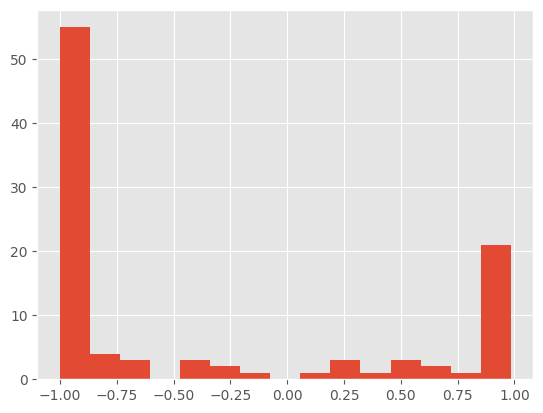

In [3]:
img, label = mnist_dataset[0]
print('Label: ', label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [4]:
def denorm(x) -> torch.Tensor:
    return Normalize(mean=(-1,), std=(2,))(x)

denorm(img)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

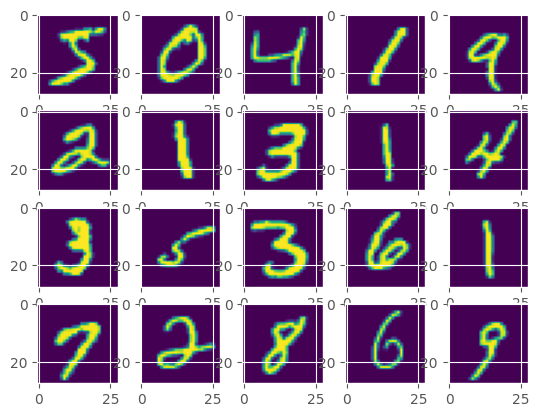

In [5]:
for i in range(20):
    image, label = mnist_dataset[i]
    plt.subplot(4, 5, i + 1)
    plt.imshow(denorm(image).permute(1, 2, 0))

In [6]:
mnist_dataset_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size) -> None:
        super(Generator, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU())
        self.hidden_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, image_size),
            nn.Tanh())

    def forward(self, x) -> torch.Tensor:
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size) -> None:
        super(Discriminator, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU())
        self.hidden_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid())
    def forward(self, x) -> torch.Tensor:
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

### Create the Generator and Discriminator

In [8]:
generator = Generator(latent_size, image_size, hidden_size)
discriminator = Discriminator(image_size, hidden_size)

In [9]:
# show the output of model
y = generator(torch.randn(2, latent_size))
discriminator(y)

tensor([[0.5061],
        [0.5065]], grad_fn=<SigmoidBackward0>)

In [10]:
loss_function = nn.BCELoss()

In [11]:
generator_optimizer = optim.Adam(generator.parameters(), lr=adam_lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=adam_lr)
# discriminator_optimizer = optim.SGD(discriminator.parameters(), lr=sqd_lr)

Discriminator Training

In [12]:
def train_discriminator(
    discriminator, 
    generator, 
    discriminator_optimizer,
    loss_function,
    real_images, 
    device, 
    batch_size, 
    latent_size
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    discriminator_optimizer.zero_grad()
    
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    real_predictions = discriminator(real_images)
    real_images_loss = loss_function(real_predictions, real_labels)
    
    z = torch.randn(batch_size, *latent_size).to(device)
    fake_images = generator(z)
    fake_predictions = discriminator(fake_images)
    fake_images_loss = loss_function(fake_predictions, fake_labels)

    loss = real_images_loss + fake_images_loss

    loss.backward()

    discriminator_optimizer.step()
    
    return loss, real_predictions, fake_predictions

Generator Training

In [13]:
def train_generator(
    discriminator,
    generator, 
    generator_optimizer, 
    loss_function,
    device, 
    batch_size, 
    latent_size
) -> Tuple[torch.Tensor, torch.Tensor]:
    generator_optimizer.zero_grad()
    
    labels = torch.ones(batch_size, 1).to(device)
    
    z = torch.randn(batch_size, *latent_size).to(device)
#     z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    images = generator(z)
    predictions = discriminator(images)
    
    loss = loss_function(predictions, labels)
    
    loss.backward()
    
    generator_optimizer.step()

    return loss, images

### Start the training proccess

In [14]:
def save_fake_images_mnist(
    generator, 
    epoch, 
    sample_dir, 
    device, 
    batch_size, 
    latent_size
) -> None:
    z = torch.randn(batch_size, latent_size).to(device)
#     z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = generator(z)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_images_file_name = f'fake_images-{epoch}.png'
    print("Saving", fake_images_file_name)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_images_file_name), nrow=10)

In [28]:
%%time
total_step = len(mnist_dataset_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(mnist_dataset_loader):
        real_images = images.reshape(batch_size, -1).to(device)
        
        discriminator_loss, real_predictions, fake_predictions = train_discriminator(
            discriminator, 
            generator, 
            discriminator_optimizer,
            loss_function,
            real_images, 
            device, 
            batch_size, 
            (latent_size,))

        generator_loss, fake_images = train_generator(
            discriminator,
            generator, 
            generator_optimizer, 
            loss_function,
            device, 
            batch_size, 
            (latent_size,))

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(discriminator_loss.item())
            g_losses.append(generator_loss.item())
            real_scores.append(real_predictions.mean().item())
            fake_scores.append(fake_predictions.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    discriminator_loss.item(),
                    generator_loss.item(),
                    real_predictions.mean().item(),
                    fake_predictions.mean().item(),
                )
            )
    break
    save_fake_images_mnist(generator, epoch + 1, sample_dir, device, batch_size, latent_size)

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
CPU times: user 92.3 ms, sys: 6.44 ms, total: 98.8 ms
Wall time: 33.4 ms


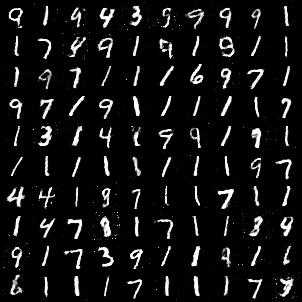

In [19]:
Image.open(os.path.join(sample_dir, 'fake_images-300.png'))

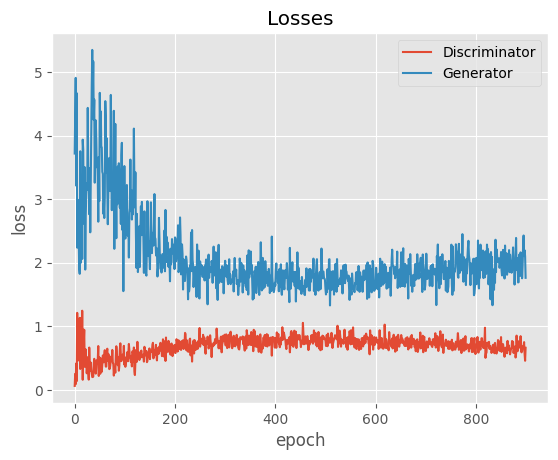

In [17]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

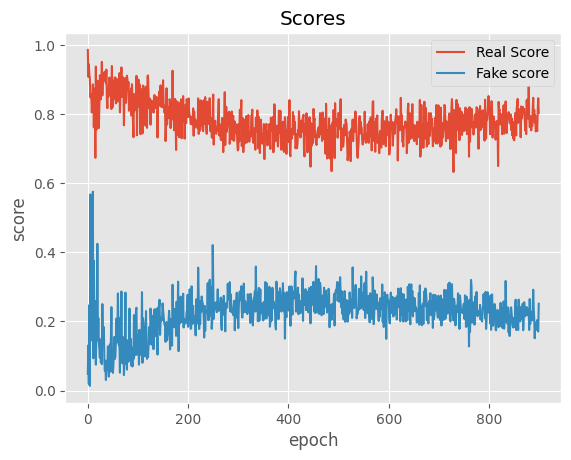

In [18]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [15]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = 'data'
    nc = 3  ## number chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = 'cpu'
    sample_dir = './dcgan_images/'

In [16]:
if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)
    
transform = transforms.Compose([
    Resize([CFG.image_size, CFG.image_size], transforms.InterpolationMode.BILINEAR),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transform)

Files already downloaded and verified


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124181, -0.74797386, -0.68470585, -0.62143791,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986]),
 <BarContainer object of 15 artists>)

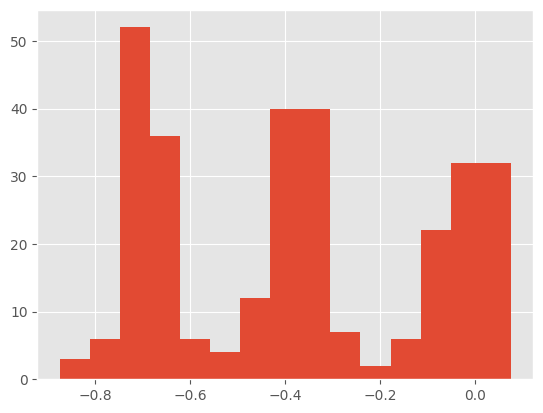

In [17]:
img, label = cifar_dataset[0]
print('Label: ', label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

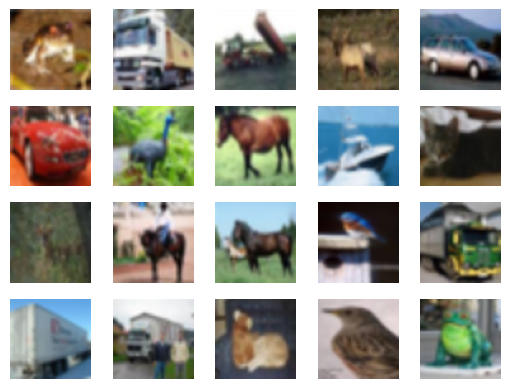

In [18]:
for i in range(20):
    image, label = cifar_dataset[i]
    ax = plt.subplot(4, 5, i + 1)
    ax.imshow(ToPILImage()(denorm(image)))
    ax.axis('off')

In [19]:
cifar_dataset_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=CFG.batch_size, shuffle=True)

### DCGAN implementation

In [20]:
class DcGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(DcGenerator, self).__init__()
        self.input_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU())
        self.hidden_layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU())
        self.hidden_layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU())
        self.hidden_layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU())
        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.output_layer(x)
        return x


class DcDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(DcDiscriminator, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU())
        self.hidden_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU())
        self.hidden_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU())
        self.hidden_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU())
        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, stride=2),
            nn.Sigmoid())

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.output_layer(x)
        return x.reshape(-1, 1)

In [21]:
dc_generator = DcGenerator(CFG.nc, CFG.nz, CFG.ndf)
dc_discriminator = DcDiscriminator(CFG.nc, CFG.ndf)

In [22]:
y_g = dc_generator(torch.randn(2, CFG.nz, 1, 1))
print(y_g.shape)
y_d = dc_discriminator(y_g)
print(y_d.view(-1).shape)

torch.Size([2, 3, 64, 64])
torch.Size([2])


In [23]:
dc_loss_function = nn.BCELoss()

In [24]:
dc_generator_optimizer = optim.Adam(dc_generator.parameters(), lr=adam_lr)
dc_discriminator_optimizer = optim.Adam(dc_discriminator.parameters(), lr=adam_lr)

### Start the training proccess

In [25]:
def save_fake_images_cifar(dc_generator, epoch, device, sample_dir, batch_size):
    z = torch.randn(batch_size, CFG.nz, 1, 1).to(device)
    fake_images = dc_generator(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_images_file_ame = f'fake_images-{epoch}.png'
    print('Saving', fake_images_file_ame)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_images_file_ame), nrow=10)

In [ ]:
%%time
total_step = len(cifar_dataset_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
dc_generator.to(CFG.device)
dc_discriminator.to(CFG.device)
# for epoch in range(CFG.num_epochs):
for epoch in range(3):
    for i, (images, _) in enumerate(cifar_dataset_loader):
#         real_images = images.reshape(CFG.batch_size, -1).to(CFG.device)
        real_images = images

        discriminator_loss, real_predictions, fake_predictions = train_discriminator(
            dc_discriminator, 
            dc_generator, 
            dc_discriminator_optimizer,
            dc_loss_function,
            real_images, 
            CFG.device, 
            CFG.batch_size, 
            (CFG.nz, 1, 1))

        generator_loss, fake_images = train_generator(
            dc_discriminator,
            dc_generator, 
            dc_generator_optimizer, 
            loss_function,
            CFG.device, 
            CFG.batch_size, 
            (CFG.nz, 1, 1))

        # Inspect the losses
        if (i + 1) % 100 == 0:
            d_losses.append(discriminator_loss.item())
            g_losses.append(generator_loss.item())
            real_scores.append(real_predictions.mean().item())
            fake_scores.append(fake_predictions.mean().item())
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    CFG.num_epochs,
                    i + 1,
                    total_step,
                    discriminator_loss.item(),
                    generator_loss.item(),
                    real_predictions.mean().item(),
                    fake_predictions.mean().item()))
    save_fake_images_cifar(dc_generator, epoch + 1, CFG.device, CFG.sample_dir, CFG.batch_size)

Epoch [0/300], Step [100/391], d_loss: 0.0046, g_loss: 7.4913, D(x): 1.00, D(G(z)): 0.00


In [ ]:
Image.open(os.path.join(CFG.sample_dir, 'fake_images-3.png'))

In [ ]:
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

In [ ]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");